In [1]:
import gym
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
import HIVTreatment_Gym
%matplotlib inline

In [2]:
def plot_running_avg(totalrewards):
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = totalrewards[max(0, t-100):(t+1)].mean()
    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

In [3]:
class SGDRegressor:
    def __init__(self, D):
        self.w = np.random.randn(D) / np.sqrt(D)
        self.lr = 0.1
    def partial_fit(self, X, Y):
        self.w += self.lr*(Y - X.dot(self.w)).dot(X)

    def predict(self, X):
        return X.dot(self.w)

In [4]:
class FeatureTransformer:
    def __init__(self, env):
        # observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        # NOTE!! state samples are poor, b/c you get velocities --> infinity
        observation_examples = np.random.random((20000, 6))*2 - 1
        scaler = StandardScaler()
        scaler.fit(observation_examples)

        # Used to converte a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        featurizer = FeatureUnion([
                ("rbf1", RBFSampler(gamma=0.05, n_components=1000)),
                ("rbf2", RBFSampler(gamma=1.0, n_components=1000)),
                ("rbf3", RBFSampler(gamma=0.5, n_components=1000)),
                ("rbf4", RBFSampler(gamma=0.1, n_components=1000))
                ])
        feature_examples = featurizer.fit_transform(scaler.transform(observation_examples))

        self.dimensions = feature_examples.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer

    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [5]:
# Holds one SGDRegressor for each action
class Model:
    def __init__(self, env, feature_transformer):
        self.env = env
        self.models = []
        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = SGDRegressor(feature_transformer.dimensions)
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        result = np.stack([m.predict(X) for m in self.models]).T
        return result
    
    def update(self, s, a, G):
        X = self.feature_transformer.transform(np.atleast_2d(s))
        self.models[a].partial_fit(X, [G])

    def sample_action(self, s, eps):
        features=self.predict
        if np.random.random() < eps:
              return self.env.action_space.sample()
        else:
              return np.argmax(self.predict(s))

In [6]:
def play_one(env, model, eps, gamma):
    observation = env.reset()
    done = False
    totalreward = 0
    iters = 0
    action = model.sample_action(observation, eps)
    for iters in range(2000):
        obs_features=model.predict(observation)
        next_observation, reward, done, info = env.step(action)

#         if done:
#             reward = -200

    
        next_obs_features = model.predict(next_observation)
        
        next_action=model.sample_action(next_observation,eps)
        
        
        # print(next.shape)
        assert(next_obs_features.shape == (1, env.action_space.n))
        assert(obs_features.shape)==(1,env.action_space.n)
        #import pdb;pdb.set_trace()
        G = reward + gamma*(eps*np.mean(next_obs_features)+(1-eps)*np.max(next_obs_features))
       
        model.update(observation, action, G)
        totalreward += reward
#         if reward == 1: # if we changed the reward to -200
#             totalreward += reward
        iters += 1
        observation=next_observation
        action=next_action
        if done:
            break

    return totalreward

In [7]:
def main():
    env = gym.make('HIV-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft)
    gamma = 0.99

    if 'monitor' in sys.argv:
        filename = os.path.basename(__file__).split('.')[0]
        monitor_dir = './' + filename + '_' + str(datetime.now())
        env = wrappers.Monitor(env, monitor_dir)


    N = 10000
    totalrewards = np.empty(N)
    costs = np.empty(N)
    for n in range(N):
        eps = 1.0/np.sqrt(n+1)
        totalreward = play_one(env, model, eps, gamma)
        totalrewards[n] = totalreward
        if n % 100 == 0:
            print("episode:", n, "total reward:", totalreward, "eps:", eps, "avg reward (last 100):", totalrewards[max(0, n-100):(n+1)].mean())

    print("avg reward for last 100 episodes:", totalrewards[-100:].mean())
    print("total steps:", totalrewards.sum())

    plt.plot(totalrewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(totalrewards)


episode: 0 total reward: 8269699.0058665145 eps: 1.0 avg reward (last 100): 8269699.0058665145
episode: 100 total reward: 86777213.65309471 eps: 0.09950371902099892 avg reward (last 100): 61533099.48731169
episode: 200 total reward: 363670460.64014554 eps: 0.07053456158585983 avg reward (last 100): 194130578.22342452
episode: 300 total reward: 1539597856.4161475 eps: 0.0576390417704235 avg reward (last 100): 946241001.2526941
episode: 400 total reward: 2955519113.3726735 eps: 0.04993761694389223 avg reward (last 100): 2076703215.3491054
episode: 500 total reward: 3349316709.3589344 eps: 0.04467670516087703 avg reward (last 100): 2871581377.0918756
episode: 600 total reward: 4598426821.676602 eps: 0.04079085082240021 avg reward (last 100): 3668868031.5166125
episode: 700 total reward: 21169003099.899784 eps: 0.0377694787300249 avg reward (last 100): 11416573640.173096
episode: 800 total reward: 15995745070.105684 eps: 0.03533326266687867 avg reward (last 100): 20149850564.913788
episode

episode: 7300 total reward: 42994181927.26673 eps: 0.011703313150272007 avg reward (last 100): 38539757417.20395
episode: 7400 total reward: 38137243664.89807 eps: 0.011623978496961555 avg reward (last 100): 38141330659.29909
episode: 7500 total reward: 43504695349.16264 eps: 0.01154623566040508 avg reward (last 100): 38314091152.673004
episode: 7600 total reward: 41403830932.03655 eps: 0.011470032110973345 avg reward (last 100): 38702579186.01313
episode: 7700 total reward: 29708817780.165436 eps: 0.011395317714291038 avg reward (last 100): 38874613065.72657
episode: 7800 total reward: 29306413179.508057 eps: 0.011322044592617122 avg reward (last 100): 37692595072.28461
episode: 7900 total reward: 41702682514.79606 eps: 0.011250166995905777 avg reward (last 100): 38433514915.04463
episode: 8000 total reward: 33269794678.076683 eps: 0.01117964118175896 avg reward (last 100): 38450869759.24588
episode: 8100 total reward: 43465032039.81436 eps: 0.011110425303554916 avg reward (last 100):

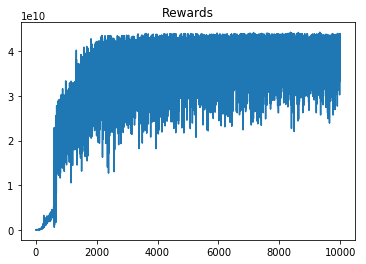

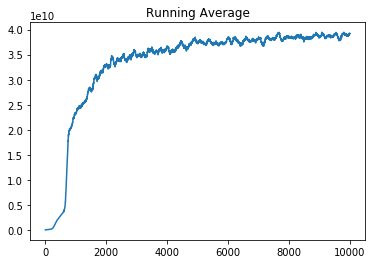

In [8]:
main()

## Approach :
  The previous implementations of KBRL are unable to converge thus we now move to a different choice of kernel and method of implementation. We decide to use the Radial Basis Function (RBF) kernel.
  
  The RBF kernel model can be thought of as a linear  model with feature extraction where the feature extractor is a RBF kernel.
  
  Mathematically the RBF kernel can be expressed as:
  $$\phi (x)=exp(-\frac{||x-c||^{2}}{\sigma^{2}})$$
  
  where:
         $x$= input vector
         $c$ = center or exemplar vector
         $\sigma$ = scale parameter.
         
  Note that $c$ is a hyper-parameter and needs to be found by experimentation.
  
  We use the RBF-sampler from scikit-learn and sample from the state space to train a linear regresor to learns its feature.
  Since we are not sure which scale parameter $\sigma$ is good we use multiple RBF kernels with different scale parameters. We also use one step of a gradient descent to integrate it with the Q learning mechanism.
  
Another implementation detail worth noting is that we only extract the features from the state $s$ and learn a different linear-model for each action.